In [1]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime, timedelta
import matplotlib.dates as mdatesx  
from itertools import zip_longest
from tudatpy.util import result2array
import math
from scipy.integrate import solve_ivp

from my_functions import sat_prop, tle_epoch_to_datetime, compute_tle_checksum,sat_prop_two_body, state_eci_to_radec, sat_prop_with_stm

spice.load_standard_kernels()

In [2]:
def measurement_model(x_eci,gs_eci):
    """
    Inputs - state of satellite in ECI and postion of ground station in ECI. 
    Units can be meters or kms, as long as they are consistent
    Outputs - right ascension and declination in radians, and measurement matrix
    """

    # Computing observables
    pos_topo = x_eci[0:3] - gs_eci
    range = np.sqrt(pos_topo[0]**2 + pos_topo[1]**2 + pos_topo[2]**2)
    # ra = math.atan2(pos_topo[1],pos_topo[0])
    ra = math.atan(pos_topo[1]/pos_topo[0])
    dec = math.asin(pos_topo[2]/range)

    h = np.array([ra, dec])

    H11 = pos_topo[0]/range
    H12 = pos_topo[1]/range
    H13 = pos_topo[2]/range
    H21 = -pos_topo[1]/(pos_topo[0]**2 * (1 + (pos_topo[1]/pos_topo[0])**2))
    H22 = 1/(pos_topo[0] * (1 + (pos_topo[1]/pos_topo[0])**2))
    H31 = -pos_topo[2] * pos_topo[0]/(range**3 * np.sqrt(1-pos_topo[2]**2/range**2))
    H32 = -pos_topo[2] * pos_topo[1]/(range**3 * np.sqrt(1-pos_topo[2]**2/range**2))
    H33 = (1/range - pos_topo[2]**2/range**3) / np.sqrt(1-(pos_topo[2]/range)**2)

    H_w_range = np.array([[H11, H12, H13,0,0,0],[H21, H22,0,0,0,0],[H31, H32, H33,0,0,0]])

    H = H_w_range[1:,:]

    return h,H


In [3]:
def ekf_update(mu, cov, z_meas,z_pred, H_matrix, R):

    # Innovation (residual) between actual and predicted measurement
    y = z_meas - z_pred

    # Innovation covariance
    S = H_matrix @ cov @ H_matrix.T + R

    # Kalman gain
    K = cov @ H_matrix.T @ np.linalg.inv(S)

    # Updated state estimate (posterior mean)
    mu_post = mu + K @ y

    # Updated covariance
    I = np.eye(len(mu))
    cov_post = (I - K @ H_matrix) @ cov

    return mu_post, cov_post

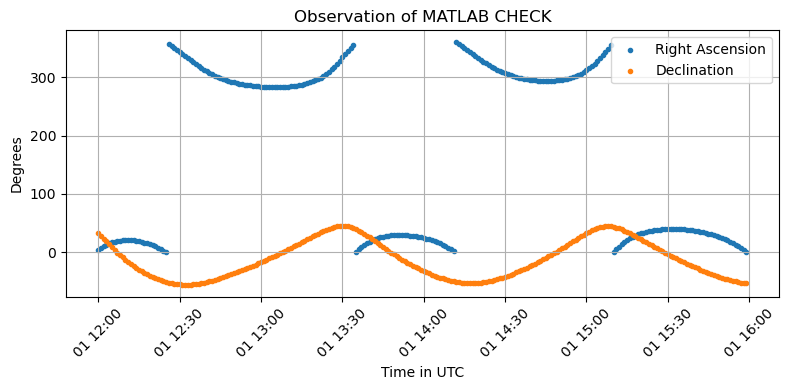

In [4]:
# targets = ["GSAT0101 (GALILEO-PFM)","STARLINK-1008","ISS (ZARYA)"]
targets = ["MATLAB CHECK"]

station_name ='REY30' 

geodetic_position = {'REY30': [3058.789875087734,20.709152020592995, -156.2600015424928]}

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'

# Initializing TLE from celestrack
tle_ISS_line1 = "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"
tle_ISS_line2 = "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"
 
tle_galileo_line1 = "1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995"
tle_galileo_line2 = "2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499"
         
tle_starlink_line1 = "1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992"
tle_starlink_line2 = "2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386"

tle_line1 = ["1 37846U 11060A   25144.52916540 -.00000075  00000+0  00000+0 0  9995","1 44714U 19074B   25145.95841286  .00000108  00000+0  26155-4 0  9992","1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"]
tle_line2 = ["2 37846  57.0978 352.2961 0003612  39.4719 320.5962  1.70475644 84499","2 44714  53.0564  38.2925 0002036  81.0993 279.0226 15.06391243305386","2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"]

tles = dict()

# Converting TLE time from UTC to TT
for idx in range (0,len(targets)):
    temp_time_utc = tle_line1[idx][18:32]
    temp_time_utc_fl = float(temp_time_utc)
    temp_time_tt = temp_time_utc_fl - 0.00081019
    temp_time_tt_fl = f"{temp_time_tt:.8f}".rjust(14)  # pad with spaces if needed
    tle_line1[idx] = tle_line1[idx][:18] + temp_time_tt_fl + tle_line1[idx][32:68]
    checksum = compute_tle_checksum(tle_line1[idx])
    tle_line1[idx] = tle_line1[idx] + checksum
    
    tles[targets[idx]] = Tle(tle_line1[idx],tle_line2[idx])


# Defining time window of simulation from TLE epoch to Tle epoch + 1 day
tle_epoch = tle_ISS_line1[18:32]
start_epoch = tle_epoch_to_datetime(tle_epoch)
end_epoch = start_epoch + timedelta(days=1)

time_format = '%Y-%m-%d %H:%M:%S'

# start_epoch_string = start_epoch.strftime(time_format)
# end_epoch_string = end_epoch.strftime(time_format)

# Time window corresponding to Heavens Above data
start_epoch_string = "2025-05-26 12:00:00"
end_epoch_string = "2025-05-26 16:00:00"

time_step_seconds = 60

# Get start and end time in UTS, Julian Day and seconds since J2000
# jd_start_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch_string, time_format))
# jd_end_epoch = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch_string, time_format))
# time_buffer = 0

# utc_simulation_start_epoch = time_conversion.julian_day_to_calendar_date(jd_start_epoch - time_buffer)
# utc_simulation_end_epoch = time_conversion.julian_day_to_calendar_date(jd_end_epoch + time_buffer)

# sim_seconds_start_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_start_epoch - time_buffer)
# sim_seconds_end_epoch = time_conversion.julian_day_to_seconds_since_epoch(jd_end_epoch + time_buffer)
sim_seconds_start_epoch = 0.0
sim_seconds_end_epoch = 14400.0 

bodies_to_create = ["Earth","Sun","Moon"]
central_bodies = ["Earth"]

# Creating Earth settings
body_settings = environment_setup.get_default_body_settings_time_limited(bodies_to_create, sim_seconds_start_epoch, sim_seconds_end_epoch, global_frame_origin, global_frame_orientation)
for target in targets:
    body_settings.add_empty_settings(target)
    body_settings.add_empty_settings(target+"_est")
   
# Add Earth Shape settings
eq_rad = 6378*1e3 # in meters
flat = 1/298
body_settings.get('Earth').shape_settings = environment_setup.shape.oblate_spherical(equatorial_radius = eq_rad,flattening = flat,)

# Add Earth Rotation model
body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
    environment_setup.rotation_model.iau_2006, global_frame_orientation,
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60),
    interpolators.interpolator_generation_settings_float(interpolators.cubic_spline_interpolation(),
                                                            sim_seconds_start_epoch, sim_seconds_end_epoch, 60))

# body_settings.get('Earth').rotation_model_settings = environment_setup.rotation_model.gcrs_to_itrs(
#     base_frame="IAU_Earth",
#     target_frame="J2000"
# )

# # CREATE ACCELERATION SETTINGS
# # Aerodynamic drag
# ref_area = np.pi * 0.5**2
# drag_coef = 2.0
# aero_coef_settings = environment_setup.aerodynamic_coefficients.constant(ref_area,[drag_coef,0.0,0.0])

# # Solar radiation pressure
# rad_coef = 1.2
# occulting_bodies_dict = dict()
# occulting_bodies_dict["Sun"] = ["Earth"]
# vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
#     ref_area, rad_coef, occulting_bodies_dict)

# body_settings.get(target).aerodynamic_coefficient_settings = aero_coef_settings
# body_settings.get(target).radiation_pressure_target_settings = vehicle_target_settings

# bodies = environment_setup.create_system_of_bodies(body_settings)
# bodies.get(target).mass = 10

# accelerations_settings_target = dict(
#     Sun=[
#         propagation_setup.acceleration.radiation_pressure(),
#         propagation_setup.acceleration.point_mass_gravity()
#     ],
#     Earth=[
#         propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
#         propagation_setup.acceleration.aerodynamic()
#     ],
#     Moon=[
#         propagation_setup.acceleration.point_mass_gravity()
#     ],
# )

# # Create global accelerations settings dictionary.
# acceleration_settings = {target: accelerations_settings_target}

# # Create numerical integrator settings
# fixed_step_size = 60.0
# integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
#     fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
# )

initial_state =    1.0e+06 * np.array([0.7577,5.222607,4.8515,0.00221321,0.00467834,-0.0053713])   # In meters

# Get true propogated satellite coordinates from tudat propogator
true_states = dict()
for target in targets:
    # true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-time_step_seconds, target, tles[target],fixed_step_size=60)
    true_states[target] = sat_prop(sim_seconds_start_epoch, sim_seconds_end_epoch-time_step_seconds, target, target_TLE=None,target_initial_state=initial_state,fixed_step_size=60)
    # true_states[target] = sat_prop_two_body(sim_seconds_start_epoch, sim_seconds_end_epoch-60, target,target_initial_state=initial_state)
    

# 1) Build a dict-of-dicts of ephemeris samples:
targets_states_dicts = {
    target: {
        float(row[0]): row[1:].reshape((6,1))
        for row in state
    }
    for target, state in true_states.items()
}

# 2) Assign each one into your body_settings:
for target, state in targets_states_dicts.items():
    body_settings.get(target).ephemeris_settings = environment_setup.ephemeris.tabulated(state,global_frame_origin,global_frame_orientation)

# Set up ground station settings
gs_alt_m = geodetic_position[station_name][0]
gs_lat_deg = geodetic_position[station_name][1]
gs_lon_deg = geodetic_position[station_name][2]

gs_ecef = [-5466071, -2403990,  2242473]
gs_eci = {}

gs_settings = []
gs_settings.append(environment_setup.ground_station.basic_station(
    station_name,[gs_alt_m,np.deg2rad(gs_lat_deg),np.deg2rad(gs_lon_deg)],element_conversion.geodetic_position_type))

body_settings.get('Earth').ground_station_settings = gs_settings

bodies = environment_setup.create_system_of_bodies(body_settings)

earth_rotation_model = bodies.get('Earth').rotation_model

true_radec = {}
true_state_initial_prop = {}

for target,state in targets_states_dicts.items():
    true_radec[target] = {}
    true_state_initial_prop[target] = {}
    
    for t in targets_states_dicts[target].keys():

        # Use RotationalEphemeris to get rotation matrix
        R_fixed_to_inertial = earth_rotation_model.body_fixed_to_inertial_rotation(t)

        # Apply rotation to get ECI position
        gs_eci[t] = R_fixed_to_inertial @ gs_ecef
        # print(gs_eci[t])
        # print(t)
    
        ra,dec = state_eci_to_radec(state[t].reshape(6,),gs_eci[t])
        true_radec[target][t] = [ra,dec]
        true_state_initial_prop[target][t] = [state[t]]

    times = []
    times_utc = []
    for t in sorted(true_radec[target].keys()):
        times.append(t)
        time_change_jd = time_conversion.seconds_since_epoch_to_julian_day(t)
        time_change_utc = time_conversion.julian_day_to_calendar_date(time_change_jd)
        times_utc.append(time_change_utc)


    ras = [np.rad2deg(true_radec[target][t][0]) % 360 for t in times]  # RA in degrees, wrapped
    decs = [np.rad2deg(true_radec[target][t][1]) for t in times]       # Dec in degrees

    # x_vals = [state[t][0] for t in times]
    # y_vals = [state[t][1] for t in times]
    # z_vals = [state[t][2] for t in times]

    # fig, axs = plt.subplots(3, 1, figsize=(6, 6))
    # axs[0].plot(times_utc, x_vals)
    # axs[0].set_title('X axis')
    # axs[1].plot(times_utc,  y_vals)
    # axs[1].set_title('Y axis')
    # axs[2].plot(times_utc,  z_vals)
    # axs[2].set_title('Z axis')
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,ras,marker='.',label='Right Ascension')
    plt.scatter(times_utc,decs,marker='.',label='Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [5]:
def getGammaMatrix(t_pre,t_cur):
    timediff = t_cur - t_pre
    Gamma = np.zeros((6,3))
    for k in range(3):
        Gamma[k,k] = 0.5*timediff**2
        Gamma[k+3,k] = timediff
    return Gamma

In [6]:
def int_twobody_stm(t, X, mu):
    """
    Combined ODE for two-body dynamics and STM (state + STM).
    
    Parameters:
    - t: current time (float)
    - X: 42-element array (6 for state, 36 for STM)
    - mu: gravitational parameter [m^3/s^2]
    
    Returns:
    - dXdt: 42-element derivative
    """

    # Extract position and velocity
    r = X[0:3]
    v = X[3:6]

    # Norm of position
    r_norm = np.linalg.norm(r)

    # Compute acceleration (2-body)
    a = -mu * r / r_norm**3

    # Build Jacobian A matrix (6x6)
    I3 = np.eye(3)
    O3 = np.zeros((3, 3))

    # d(acceleration)/d(position)
    term1 = mu * (3 * np.outer(r, r) / r_norm**5 - I3 / r_norm**3)
    A_top = np.hstack([O3, I3])
    A_bot = np.hstack([term1, O3])
    A = np.vstack([A_top, A_bot])  # Full 6x6 Jacobian

    # Extract current STM and reshape to 6x6
    Phi = X[6:].reshape((6, 6))

    # Compute STM derivative
    dPhi_dt = A @ Phi

    # Build full derivative vector
    dXdt = np.zeros(42)
    dXdt[0:3] = v
    dXdt[3:6] = a
    dXdt[6:] = dPhi_dt.flatten()

    return dXdt


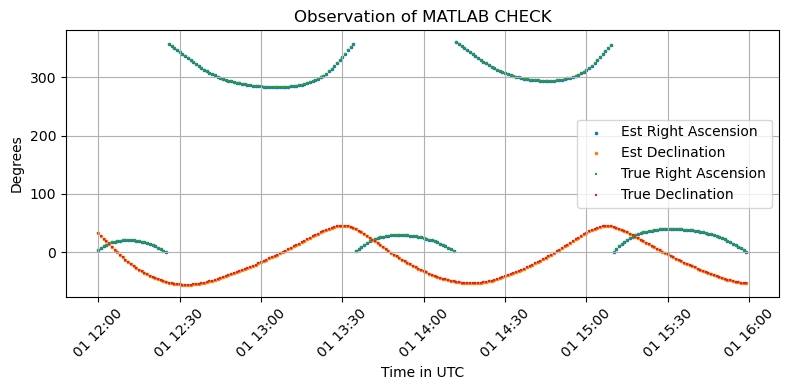

In [7]:
# Noise matrices
q_pos = 1e-12    # km^2
Q = np.eye(3) * q_pos  # km^2
R = np.diag([1e-10 * 0.235043863818291, 1e-10 * 0.235043863818291])   # rad^2
R_std = np.sqrt(R[0][0])
# R = np.diag([1e-8,1e-8])

est_state = {target: dict() for target in targets}
true_state = {target: dict() for target in targets}
est_cov   = {target: dict() for target in targets}
est_ra    = {target: dict() for target in targets}  # will store in radians
est_dec    = {target: dict() for target in targets}
true_ra_deg    = {target: dict() for target in targets}
true_dec_deg    = {target: dict() for target in targets}
resids    = {target: dict() for target in targets}

Kk_norm = []

Xref_Stm0 = {}
x_true = {}
for target in targets:
    Xref_Stm0[target] = {}
    # get initial mean from TLE ephemeris at start time
    # tle_ephem = environment.TleEphemeris("Earth","J2000", tles[target], False)
    # x_true[target] = tle_ephem.cartesian_state(sim_seconds_start_epoch).flatten()
    x_true[target] = initial_state / 1000        # km
    Xref_Stm0[target]["Xref"] = x_true[target]   # km
    Xref_Stm0[target]["Phi0"] = np.eye(6)        # unitless
    

station_id = ('Earth', station_name)


for target in targets:
    t_pre = times[0]
    xhat_k_prev = np.zeros(6)
    P_est = np.diag([1e2,1e2,1e2,1e-4,1e-4,1e-4])    # km^2

    for idx,t in enumerate(times):
        tk = times[idx]

        # True propagation 
        if idx == 0:
            x_true[target] = Xref_Stm0[target]["Xref"]   # km
        else:
            # prop_temp = sat_prop(t_pre,tk,target,target_TLE= None, target_initial_state=x_true[target])
            # x_true[target] = prop_temp[-1][1:]
            prop_temp,_ = sat_prop_two_body(t_pre,tk,target,x_true[target]*1000)
            x_true[target] = list(prop_temp.values())[-1].flatten() / 1000

        # True angles
        # temp_true_ra_rad = (true_radec[target][t][0])
        # temp_true_dec_rad = (true_radec[target][t][1])

        temp_true_ra_rad,temp_true_dec_rad = state_eci_to_radec(x_true[target],gs_eci[tk]/1000)
        # Observation
        zk = np.array([temp_true_ra_rad, temp_true_dec_rad]) + np.random.normal(0, R_std, size=2)
        
        # Prediction
        if idx == 0:
            Xref_k = Xref_Stm0[target]["Xref"]
            Phi_k = Xref_Stm0[target]["Phi0"]
        else:
            # 2 body dynamics
            # state_pred = prop_temp[-1][1:]
            # r_prev = est_state[target][idx][:3]  # position vector at time k-1
            # r_norm = np.linalg.norm(r_prev)
            # if (not np.isfinite(r_norm)) or (r_norm < 1e-2):
            #     print(f"Warning: r_norm = {r_norm:.3e} < 1e-3 at idx {idx}, t={t}")
            #     A_r = np.zeros((3,3))
            # elif(r_norm > 1e15 ):
            #     print(f"Warning: r_norm = {r_norm:.3e} > 1e15 at idx {idx}, t={t}")
            #     A_r = np.zeros((3,3))
            # else:
            #     dt = 60
            #     I3  = np.eye(3)
            #     rrT = np.outer(r_prev, r_prev)
            #     mu  = 398600.4418e9
            #     A_r = -mu * (I3 / r_norm**3 - 3 * rrT / r_norm**5)
            # F_k = np.block([[I3, dt * I3],
            #             [A_r * dt, I3   ]])
            # cov_pred = F_k @ est_cov[target][idx] @ (F_k.T) + Q
            # print(Xref_prev[0:3])
            temp_state,stm_k = sat_prop_two_body(t_pre,tk,target,Xref_prev*1000)
            Xref_k = list(temp_state.values())[-1].flatten() / 1000
            Phi_k = list(stm_k.values())[-1]  # 6x6 matrix

            # # Full force model
            # temp_state,stm_k = sat_prop_with_stm(t,t+time_step_seconds,target,Xref_prev,fixed_step_size=60)
            # Xref_k = list(temp_state.values())[-1].flatten()
            # Phi_k = list(stm_k.values())[-1]  # 6x6 matrix
        
        # print(np.linalg.norm(Xref_k))
        # print(np.linalg.norm(Phi_k,ord=2))

        Gammak = getGammaMatrix(t_pre, tk)  
        xhat_k_kminus1 = Phi_k @ xhat_k_prev
        P_k_kminus1 = Phi_k @ P_est @ Phi_k.T + Gammak @ Q @ Gammak.T


        # EKF update
        gk,H_matrix = measurement_model(Xref_k,gs_eci[t]/1000)   # Both arguments in km
        yk = zk - gk
        S_cov = H_matrix @ P_k_kminus1 @ H_matrix.T + R
        Kk = P_k_kminus1 @ H_matrix.T @ np.linalg.inv(S_cov)

        Kk_norm.append(np.linalg.norm(Kk,'fro'))

        xhat_k = xhat_k_kminus1 + Kk @ (yk - H_matrix @ xhat_k_kminus1)
        P_est = (np.eye(6) - Kk @ H_matrix) @ P_k_kminus1 @ (np.eye(6) - Kk @ H_matrix).T + Kk @ R @ Kk.T
        x_est = Xref_k + xhat_k

        resids_temp = yk - H_matrix @ xhat_k

        # Setting values for next iteration
        Xref_prev = Xref_k
        xhat_k_prev = xhat_k
        t_pre = tk
        # Xref_stm_prev = np.concatenate([Xref_Stm0,Xref_Stm0[target]["Phi0"]])
     
        ra_post,dec_post = state_eci_to_radec(x_est,gs_eci[t]/1000)

        # Storing stuff
        true_state[target][idx] = x_true[target]
        est_state[target][idx] = x_est
        est_cov[target][idx] = P_est
        est_ra[target][idx] = (np.rad2deg(ra_post) % 360)
        est_dec[target][idx] = (np.rad2deg(dec_post))
        true_ra_deg[target][idx] = np.rad2deg(temp_true_ra_rad) % 360
        true_dec_deg[target][idx] = np.rad2deg(temp_true_dec_rad)
        resids[target][idx] = resids_temp

    plt.figure(figsize=(8, 4))
    plt.scatter(times_utc,est_ra[target].values(),marker='x',s=3,label='Est Right Ascension')
    plt.scatter(times_utc,est_dec[target].values(),marker='x',s=3,label='Est Declination')
    plt.scatter(times_utc,true_ra_deg[target].values(),marker='+',s=3,label='True Right Ascension')
    plt.scatter(times_utc,true_dec_deg[target].values(),marker='+',s=3,label='True Declination')
    plt.title('Observation of '+target)
    plt.xlabel('Time in UTC')
    plt.ylabel('Degrees')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

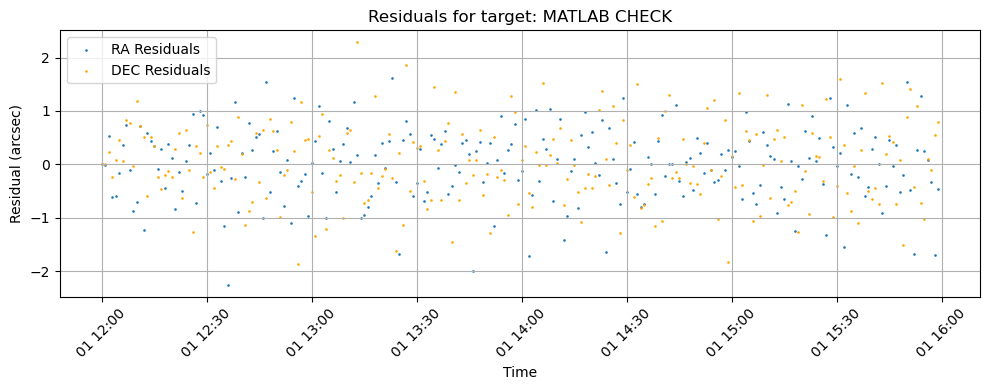

In [9]:
idxs = sorted(resids[target].keys())

residual_array = np.array([resids[target][i] for i in idxs])  # shape (N, 2)

# Split into RA and DEC residuals
ra_residuals = residual_array[:, 0] * 3600
dec_residuals = residual_array[:, 1] * 3600


plt.figure(figsize=(10, 4))

plt.scatter(times_utc, np.rad2deg(ra_residuals),marker='.',s=3, label="RA Residuals")
plt.scatter(times_utc, np.rad2deg(dec_residuals),marker='.',s=3, label="DEC Residuals", color='orange')
plt.ylabel("Residual (arcsec)")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.title(f"Residuals for target: {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



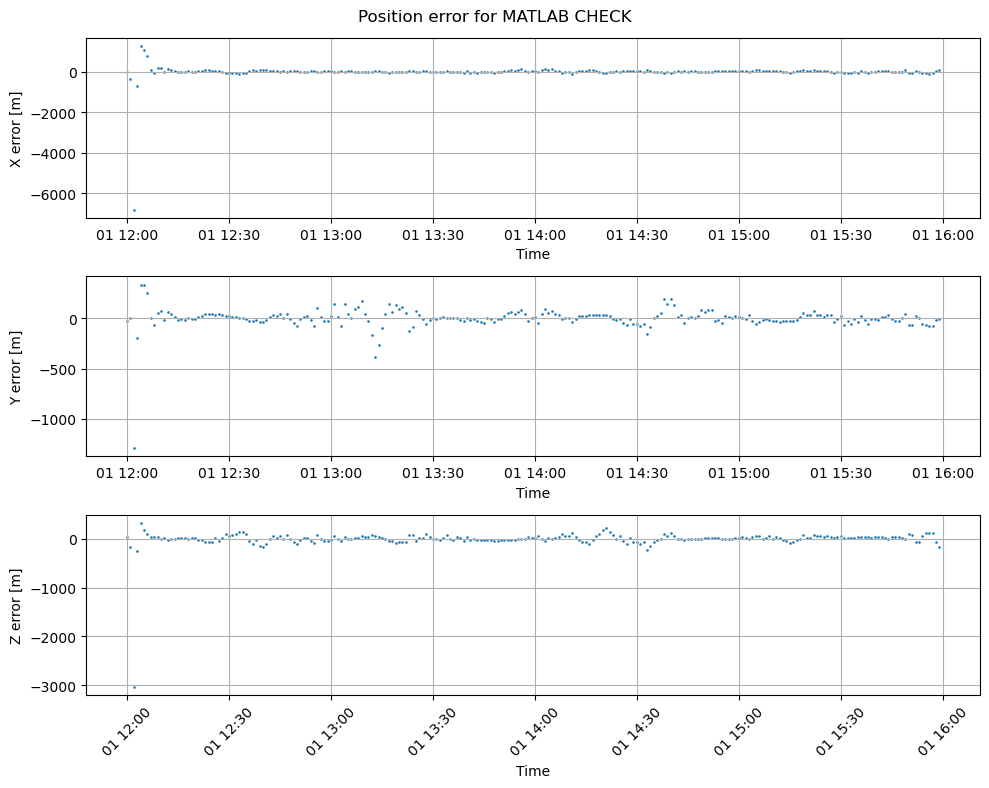

In [12]:
# true_state_array = np.array([
#     np.squeeze(true_state_initial_prop[target][t]).flatten()
#     for t in times
# ]) 
true_state_array = np.array([true_state[target][i] for i in idxs]) 
est_state_array = np.array([est_state[target][i] for i in idxs])  

er_state = (true_state_array - est_state_array) * 1000
x_err = er_state[:,0]
y_err = er_state[:,1]
z_err = er_state[:,2]


plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.scatter(times_utc, (x_err),marker='.',s=3, label="X error")
plt.ylabel("X error [m]")
plt.xlabel("Time")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.scatter(times_utc, (y_err),marker='.',s=3, label="Y error")
plt.ylabel("Y error [m]")
plt.xlabel("Time")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.scatter(times_utc, (z_err),marker='.',s=3, label="Z error")
plt.ylabel("Z error [m]")
plt.xlabel("Time")
plt.grid(True)

plt.suptitle(f"Position error for {target}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

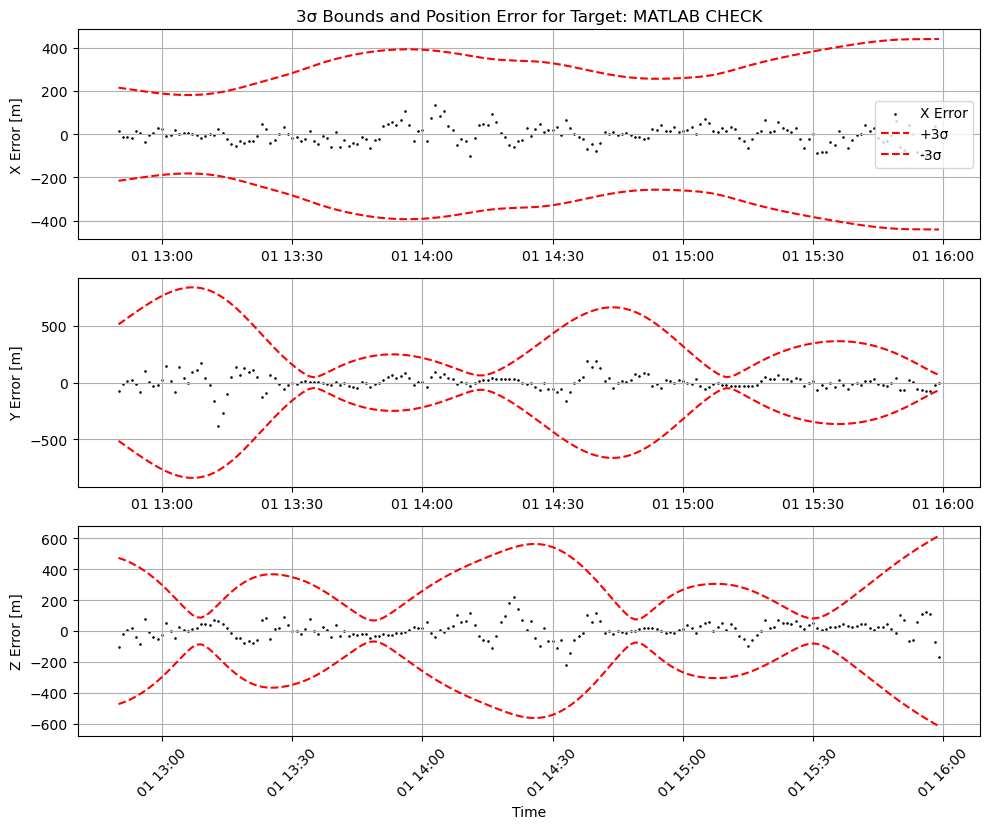

In [17]:
cov_array = np.array([est_cov[target][i] for i in idxs])              # shape (N, 6, 6)

sigma_3 = 3 * np.sqrt(np.array([np.diag(P)[0:3] for P in cov_array])) * 1000 # shape (N, 3)

x_3sig, y_3sig, z_3sig = sigma_3[:, 0], sigma_3[:, 1], sigma_3[:, 2]

# Time vector (assumed pre-defined)
t_plot = times_utc[:]  # or just `idxs` if no time vector

# Plotting
plt.figure(figsize=(10, 8))

for i, (err, sig, label) in enumerate(zip([x_err, y_err, z_err],
                                          [x_3sig, y_3sig, z_3sig],
                                          ['X', 'Y', 'Z'])):
    plt.subplot(3, 1, i + 1)
    plt.scatter(t_plot[50:], err[50:],marker='.',s=3, label=f'{label} Error', color='black')
    plt.plot(t_plot[50:], sig[50:], 'r--', label='+3σ')
    plt.plot(t_plot[50:], -sig[50:], 'r--', label='-3σ')
    plt.ylabel(f'{label} Error [m]')
    plt.grid(True)
    if i == 2:
        plt.xlabel("Time")
    if i == 0:
        plt.title(f"3σ Bounds and Position Error for Target: {target}")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()